In [1]:
import numpy as np
import pylab as pp
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
import os

pp.style.use("bmh")

# Technical Analysis library
import ta

# Neural Network library
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
os.chdir("D:\Stocks")
# Loading in the Data
df = pd.read_csv("005930.KS.csv")

In [3]:
## Datetime conversion
df['Date'] = pd.to_datetime(df.Date)

# Setting the index
df.set_index('Date', inplace=True)

# Dropping any NaNs
df.dropna(inplace=True)



## Technical Indicators

# Adding all the indicators
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Dropping everything else besides 'Close' and the Indicators
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

# Only using the last 1000 days of data to get a more accurate representation of the current market climate
# df = df.tail(1000)



## Scaling

# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

close_scaler.fit(df[['Close']])

# Normalizing/Scaling the DF
scaler = RobustScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

c:\users\light\appdata\local\programs\python\python38\lib\site-packages\ta\trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
c:\users\light\appdata\local\programs\python\python38\lib\site-packages\ta\trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [4]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    pp.figure(figsize=(16,5))
    pp.plot(history['val_loss'])
    pp.plot(history['loss'])
    pp.legend(['val_loss', 'loss'])
    pp.title('Loss')
    pp.xlabel('Epochs')
    pp.ylabel('Loss')
    pp.show()
    
    pp.figure(figsize=(16,5))
    pp.plot(history['val_accuracy'])
    pp.plot(history['accuracy'])
    pp.legend(['val_accuracy', 'accuracy'])
    pp.title('Accuracy')
    pp.xlabel('Epochs')
    pp.ylabel('Accuracy')
    pp.show()
    
    
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass
          

def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(n_per_in, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1], 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

In [5]:
# How many periods looking back to learn
n_per_in  = 90
# How many periods to predict
n_per_out = 30
# Features 
n_features = df.shape[1]
# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [6]:

## Creating the NN

# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(90, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=4, 
            n_nodes=30, 
            activation=activ)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

## Fitting and Training
res = model.fit(X, y, epochs=50, batch_size=128, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 90)            59040     
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 30)            14520     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dense (Dense)                (None, 30)                1830      
Total params: 97,230
Trainable params: 97,230
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
9/9 [==============================] - 3s 374ms/step - loss: 0.2180 - accuracy: 0.0216 - val_loss: 0.1755 - val_accuracy: 0.0336
Epoch 2/50
9/9 [==============================] - 2s 209ms/step - loss: 0.0684 - accuracy: 0.0376 - val_loss: 

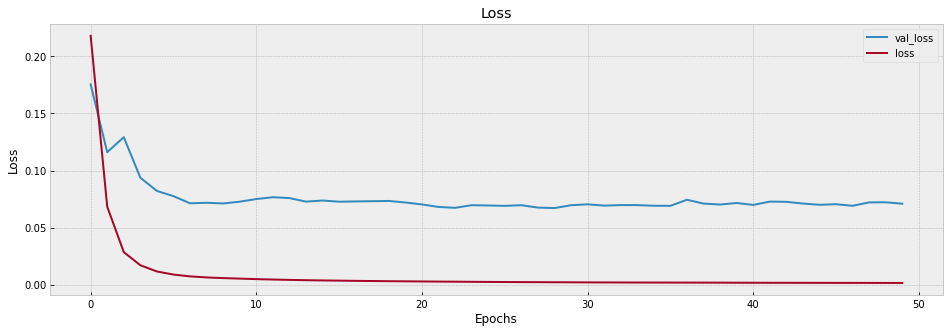

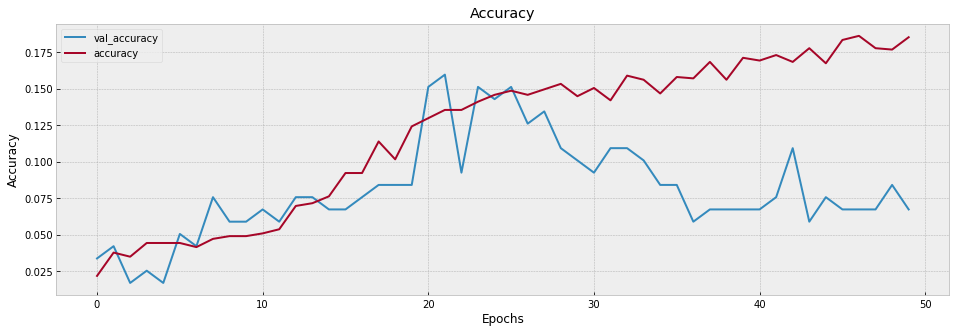

In [7]:
visualize_training_results(res)

RMSE: 1533.5568435851962


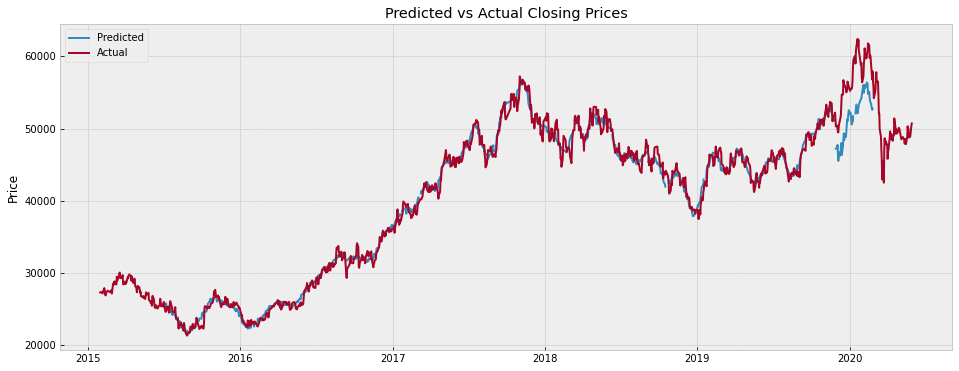

In [8]:

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = validater(n_per_in, n_per_out)

# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
pp.figure(figsize=(16,6))

# Plotting those predictions
pp.plot(predictions, label='Predicted')

# Plotting the actual values
pp.plot(actual, label='Actual')

pp.title(f"Predicted vs Actual Closing Prices")
pp.ylabel("Price")
pp.legend ()
# pp . xlim ( '2018-05' , '2020-05' )
pp.show()

                   Close
2020-06-01  48723.429688
2020-06-02  48808.167969
2020-06-03  49026.847656
2020-06-04  48772.574219
2020-06-05  49128.457031
2020-06-08  49828.875000
2020-06-09  49137.699219
2020-06-10  50001.101562
2020-06-11  49169.363281
2020-06-12  49263.414062
2020-06-15  50063.875000
2020-06-16  49895.261719
2020-06-17  50172.453125
2020-06-18  51105.671875
2020-06-19  49920.984375
2020-06-22  50662.859375
2020-06-23  50277.933594
2020-06-24  50853.261719
2020-06-25  50460.382812
2020-06-26  51015.218750
2020-06-29  51013.480469
2020-06-30  51112.144531
2020-07-01  50472.656250
2020-07-02  50717.363281
2020-07-03  50362.796875
2020-07-06  50388.273438
2020-07-07  49876.921875
2020-07-08  50646.832031
2020-07-09  49498.109375
2020-07-10  50359.531250


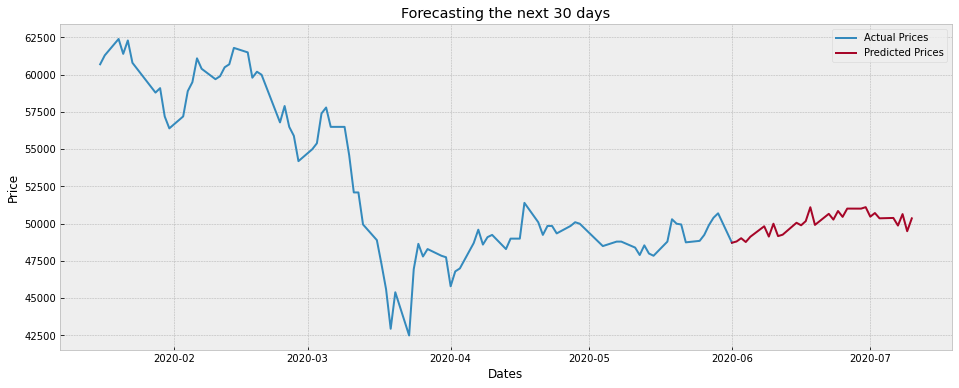

In [9]:

# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
                      index=df.Close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
pp.figure(figsize=(16,6))
pp.plot(actual, label="Actual Prices")
pp.plot(preds, label="Predicted Prices")
pp.ylabel("Price")
pp.xlabel("Dates")
pp.title(f"Forecasting the next {len(yhat)} days")
pp . legend ()
pp.show()